In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import sklearn as sk
import joblib
#from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score,cross_validate

In [2]:
random_seed = 108
test_size = 0.2

In [3]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score,f1_score
def evaluate_model(model,X,y):
    yhat = model.predict(X)
    yhat_proba = model.predict_proba(X)[:,1]
    result_dict = {}
    result_dict['accuracy'] = [accuracy_score(y,yhat)]
    result_dict['precision'] = [precision_score(y,yhat)]
    result_dict['recall'] = [recall_score(y,yhat)]
    result_dict['f1_score'] = [f1_score(y,yhat)]
    result_dict['auc'] = [roc_auc_score(y,yhat_proba)]
    
    df = pd.DataFrame.from_dict(result_dict)
    return df

In [4]:
test_df = pd.DataFrame.from_dict(
    {'model': [],
    'accuracy':[],
     'precision':[],
     'recall':[],
     'f1_score':[],
     'auc':[],
     'outcome':[]})

In [5]:
df = pd.read_excel(io='AUSCOVID_DATA_2023-04-02_1133.xlsx')

In [6]:
# excluded efgr as derivative of creatinine
# 
cols = ['age','sex','healthcare_worker','hypertension',
        'hypercholesterolemia',
       'diabetes' ,'smoker','copd','asthma','ckd','dialysis','height','weight','sbp','dbp',
        'heart_rate','respiratory_rate','temperature','spo2','crp',
        'lymphocytes','total_wcc','platelets','albumin','ldh','d_dimer','ferritin','haemoglobin',
        'creatinine','alt','lactate_venous','chest_xray','vaccinated','pacemaker','troponin_uln',
         #'coronary_artery_disease',
    #'heart_failure_cardiomyopathy',
    #'af_flutter',
    #'severe_valvular_disease',
    #'stroke_tia',
    #'pad']
        'coronary_med_history_col']

# get rid of past medical_history
# 'fio2','po2','pco2'

coronary_med_history_col = [
    'coronary_artery_disease',
    'heart_failure_cardiomyopathy',
    'af_flutter',
    'severe_valvular_disease',
    'stroke_tia',
    'pad']

cardio_complication = [
    'pericarditis',
    'new_2nd_degree_heart_block',
    'new_3rd_degree_heart_block',
    'conscious_sustained_vt',
    'new_cardiomyopathy_hf',
    'new_af_flutter',
    'myocarditis_myopericarditis',
    'pulm_embolus',
    'cardiac_arrest'
]

# replace No's to 0
for col in coronary_med_history_col + cardio_complication + ['past_medical_history']:
    df[col] = df[col].replace(2, 0)


df['death'] = [1 if x == 1 or x == 2 else 0 for x in df['discharge_status']]
df['vaccinated'] = [1 if x == 2 or x == 3 or  x == 4 else 0 for x in df['vaccination_status']]
df['pacemaker'] = [1 if x == 1 else 0 for x in df['ppm_icd']]
df['coronary_med_history_col'] = df[coronary_med_history_col].any(axis=1)


categorical_col = ['sex','healthcare_worker','hypertension',
        'hypercholesterolemia','diabetes', 'smoker','copd','asthma','ckd','dialysis',
                   'chest_xray','vaccinated','pacemaker','troponin_uln',
                     #'coronary_artery_disease',
    #'heart_failure_cardiomyopathy',
    #'af_flutter',
    #'severe_valvular_disease',
    #'stroke_tia',
    #'pad']
             'coronary_med_history_col']



predictor = ['intubation_dummy','death','cardio_complication']

df['intubation_dummy'] =  [1 if x == 1 else 0 for x in df['intubation']]
df['cardio_complication'] = df[cardio_complication].any(axis=1).astype(float)


data_predictor = df[predictor]
data = df[cols+predictor]

In [7]:
float_col = ['height','sbp','dbp','heart_rate','weight','temperature','spo2','crp',
        'lymphocytes','total_wcc','platelets','albumin','ldh','d_dimer','ferritin','haemoglobin',
        'creatinine','alt','lactate_venous']
int_col = ['age']

In [8]:
data['platelets'] = data['platelets'].astype(str).str.replace(",", "").str.replace(".", "").astype(float)

C:\Users\Harrison Nguyen\AppData\Local\Temp\ipykernel_10388\935426440.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['platelets'] = data['platelets'].astype(str).str.replace(",", "").str.replace(".", "").astype(float)


In [9]:
df_dummy =  pd.get_dummies(
        data,
        columns = categorical_col, 
        dummy_na=False,
        drop_first=True)

In [10]:
from sklearn.model_selection import train_test_split
train,test= train_test_split(df_dummy, test_size=test_size, random_state=random_seed)


In [11]:
pd.DataFrame(columns = test.drop(predictor, axis=1).columns).to_csv("dataframe_template.csv")

In [42]:
df_dummy.shape

(1714, 41)

In [43]:
train.shape

(1371, 39)

In [44]:
test.shape

(343, 39)

In [45]:
predictor

['intubation_dummy', 'death', 'cardio_complication']

In [50]:
cont_describe = data[float_col+int_col].describe()

In [51]:
cont_describe = pd.concat([cont_describe,pd.DataFrame(data[float_col+int_col].isna().sum()).T]).rename(index={0:'NA'})
cont_describe.loc['NA_perc',:] = cont_describe.loc['NA',:]/data.shape[0]*100

In [52]:
cont_describe

,height,sbp,dbp,heart_rate,weight,temperature,spo2,crp,lymphocytes,total_wcc,platelets,albumin,ldh,d_dimer,ferritin,haemoglobin,creatinine,alt,lactate_venous,age
count,614.000000,1627.000000,1563.000000,1662.000000,842.000000,1600.000000,1576.000000,1426.000000,1628.000000,1639.000000,1630.000000,1495.000000,825.000000,850.000000,784.000000,1633.000000,1635.000000,1439.000000,753.000000,1714.000000
mean,169.025098,130.825446,75.937940,91.676294,83.243575,37.412194,94.317259,69.306311,1.279275,6.824106,216.684663,34.265645,355.506545,1.529095,920.203941,133.234415,97.465627,43.324670,2.292244,60.101517
std,15.382989,22.290247,13.013265,18.200632,22.477981,2.032940,5.225175,71.962239,3.116125,6.261622,145.772151,11.080534,194.677898,6.091416,1378.932321,19.451262,90.505991,53.618129,12.717740,20.625993
min,1.750000,70.000000,35.000000,31.000000,7.000000,26.400000,30.000000,0.400000,0.000000,0.400000,4.000000,0.340000,1.200000,0.001060,0.230000,5.300000,2.700000,1.300000,0.070000,18.000000
25%,163.000000,115.000000,69.000000,79.000000,68.625000,36.600000,93.000000,16.000000,0.700000,4.400000,153.000000,31.000000,237.000000,0.470000,228.000000,123.000000,63.000000,19.000000,1.100000,43.000000
50%,170.000000,130.000000,76.000000,90.000000,80.000000,37.300000,96.000000,47.000000,1.000000,5.800000,198.000000,34.000000,308.000000,0.720000,513.000000,134.000000,78.000000,29.000000,1.400000,62.000000
75%,177.000000,145.000000,84.000000,103.000000,94.575000,38.000000,97.000000,97.000000,1.400000,7.735000,254.000000,37.000000,427.000000,1.170000,1066.750000,146.000000,99.500000,48.000000,1.800000,78.000000
max,200.000000,233.000000,150.000000,169.000000,250.000000,99.000000,100.000000,469.000000,114.300000,150.000000,3354.000000,354.000000,2026.000000,152.250000,17642.000000,201.000000,1254.000000,810.000000,265.000000,101.000000
NA,1100.000000,87.000000,151.000000,52.000000,872.000000,114.000000,138.000000,288.000000,86.000000,75.000000,84.000000,219.000000,889.000000,864.000000,930.000000,81.000000,79.000000,275.000000,961.000000,0.000000
NA_perc,64.177363,5.075846,8.809802,3.033839,50.875146,6.651109,8.051342,16.802800,5.017503,4.375729,4.900817,12.777130,51.866978,50.408401,54.259043,4.725788,4.609102,16.044341,56.067678,0.000000


In [53]:
cont_describe_train = train[float_col+int_col].describe()
cont_describe_train = pd.concat([cont_describe_train,pd.DataFrame(train[float_col+int_col].isna().sum()).T]).rename(index={0:'NA'})
cont_describe_train.loc['NA_perc',:] = cont_describe_train.loc['NA',:]/train.shape[0]*100

In [54]:
cont_describe_test = test[float_col+int_col].describe()
cont_describe_test = pd.concat([cont_describe_test,pd.DataFrame(test[float_col+int_col].isna().sum()).T]).rename(index={0:'NA'})
cont_describe_test.loc['NA_perc',:] = cont_describe_test.loc['NA',:]/test.shape[0]*100

In [55]:
cont_describe_train

,height,sbp,dbp,heart_rate,weight,temperature,spo2,crp,lymphocytes,total_wcc,platelets,albumin,ldh,d_dimer,ferritin,haemoglobin,creatinine,alt,lactate_venous,age
count,510.000000,1302.000000,1249.000000,1327.000000,692.000000,1282.000000,1261.000000,1130.000000,1302.000000,1312.000000,1304.000000,1194.000000,654.000000,675.000000,625.000000,1306.000000,1304.000000,1144.000000,610.000000,1371.000000
mean,168.781471,130.314900,75.703763,91.636021,82.442919,37.419969,94.306899,70.374779,1.323026,6.915587,218.000000,34.189397,354.255199,1.398890,922.932624,132.806126,97.199080,42.477448,2.425836,60.296134
std,15.946091,22.143771,12.935317,18.234214,21.426753,2.212876,5.300362,73.467044,3.458140,6.825749,157.518526,11.194252,201.193478,3.434882,1350.191855,19.246544,89.155399,53.208991,14.100840,20.577746
min,1.750000,70.000000,35.000000,44.000000,7.000000,26.400000,30.000000,0.400000,0.000000,0.400000,4.000000,0.340000,1.200000,0.001060,0.230000,5.300000,3.600000,1.300000,0.070000,18.000000
25%,163.000000,115.000000,69.000000,79.000000,68.000000,36.600000,93.000000,16.000000,0.700000,4.400000,153.000000,31.000000,233.500000,0.470000,239.000000,122.000000,63.000000,19.000000,1.100000,43.000000
50%,170.000000,129.000000,76.000000,90.000000,80.000000,37.300000,96.000000,48.000000,1.000000,5.800000,199.000000,34.000000,307.500000,0.730000,533.000000,134.000000,78.000000,29.000000,1.400000,62.000000
75%,177.000000,144.000000,84.000000,103.000000,93.000000,38.000000,97.000000,98.000000,1.400000,7.800000,254.250000,37.000000,422.000000,1.150000,1074.000000,145.000000,99.000000,48.000000,1.800000,78.000000
max,200.000000,233.000000,150.000000,169.000000,176.400000,99.000000,100.000000,469.000000,114.300000,150.000000,3354.000000,354.000000,2026.000000,49.720000,17642.000000,196.000000,1182.000000,810.000000,265.000000,101.000000
NA,861.000000,69.000000,122.000000,44.000000,679.000000,89.000000,110.000000,241.000000,69.000000,59.000000,67.000000,177.000000,717.000000,696.000000,746.000000,65.000000,67.000000,227.000000,761.000000,0.000000
NA_perc,62.800875,5.032823,8.898614,3.209336,49.525894,6.491612,8.023341,17.578410,5.032823,4.303428,4.886944,12.910284,52.297593,50.765864,54.412837,4.741065,4.886944,16.557257,55.506929,0.000000


In [57]:
final_describe = pd.concat(dict(total = cont_describe.T, train = cont_describe_train.T,test=cont_describe_test.T),axis=1)

In [58]:
final_describe.to_csv("result/data/continuous_variable_summary.csv")

In [67]:
for c in categorical_col+predictor:
    df_sub = pd.concat([
        df[c].value_counts(dropna=False),
        df[c].value_counts(dropna=False,normalize=True)*100,
        train[c].value_counts(dropna=False).rename('train_count'),
        train[c].value_counts(dropna=False,normalize=True).rename('train_proportion')*100,
        test[c].value_counts(dropna=False).rename('test_count'),
        test[c].value_counts(dropna=False,normalize=True).rename('test_proportion')*100,
    ]
    ,axis=1).sort_index()
    df_sub.to_csv("result/data/" + c + "_summary.csv")

In [68]:
df_sub

,count,proportion,train_count,train_proportion,test_count,test_proportion
cardio_complication,,,,,,
0.0,1624,94.749125,1297,94.60248,327,95.335277
1.0,90,5.250875,74,5.39752,16,4.664723


# Figures

In [63]:
model_dict = {
    'l1': 'l1_feature_selection_median_impute_oversample',
    'l2': 'l2_feature_selection_median_impute_oversample',
    #'EN': 'elasticnet_feature_selection_median_impute_oversample',
    'SVM' : 'svm_median_impute_feature_select_oversample',
    'DT': 'decision_feature_selection_median_impute_oversample',
    'RF': 'rf_selection_median_impute_final_oversample',
    'AB': 'adaboost_median_impute_feature_oversample',
    'GB': 'gradboost_median_impute_feature_oversample',
    
}

In [64]:
for p in predictor:
    y_test = test[p]
    X_test = test.drop(predictor, axis=1)
    for k,v in model_dict.items():
        model_name = v
        test_pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
        test_result_df = evaluate_model(test_pipe,X_test,y_test)
        test_result_df["outcome"] = p
        test_result_df["model"] = model_name

        test_df = pd.concat([test_df,test_result_df],ignore_index=True)

In [65]:
test_df

,model,accuracy,precision,recall,f1_score,auc,outcome
0,l1_feature_selection_median_impute_oversample,0.752187,0.129870,0.357143,0.190476,0.695692,intubation_dummy
1,l2_feature_selection_median_impute_oversample,0.752187,0.139241,0.392857,0.205607,0.708503,intubation_dummy
2,svm_median_impute_feature_select_oversample,0.542274,0.122807,0.750000,0.211055,0.729365,intubation_dummy
3,decision_feature_selection_median_impute_overs...,0.705539,0.165138,0.642857,0.262774,0.678685,intubation_dummy
4,rf_selection_median_impute_final_oversample,0.766764,0.157895,0.428571,0.230769,0.718254,intubation_dummy
5,adaboost_median_impute_feature_oversample,0.752187,0.156627,0.464286,0.234234,0.732483,intubation_dummy
6,gradboost_median_impute_feature_oversample,0.857143,0.111111,0.107143,0.109091,0.675397,intubation_dummy
7,l1_feature_selection_median_impute_oversample,0.819242,0.262295,0.484848,0.340426,0.798436,death
8,l2_feature_selection_median_impute_oversample,0.810496,0.250000,0.484848,0.329897,0.798631,death
9,svm_median_impute_feature_select_oversample,0.833819,0.269231,0.424242,0.329412,0.792962,death


In [67]:
test_df.to_csv("result/final_outcome.csv")

In [68]:
test_df = pd.read_csv("result/final_outcome.csv",index_col=0)

In [69]:
best_result = test_df.sort_values('auc',ascending=False).groupby("outcome").head(1)

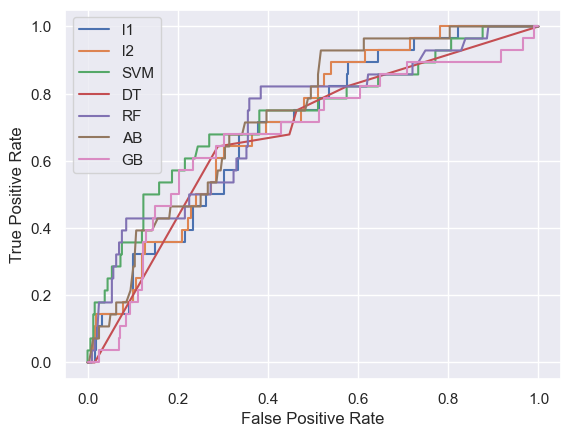

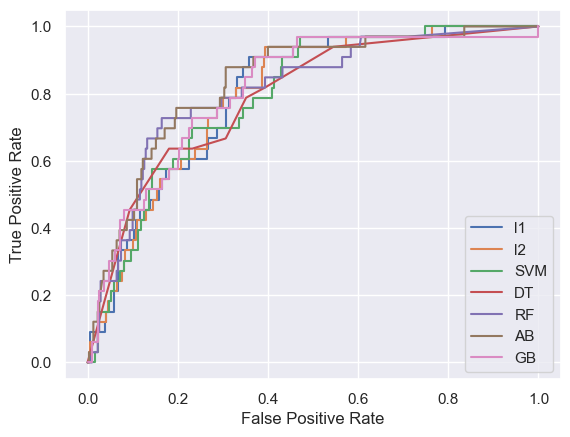

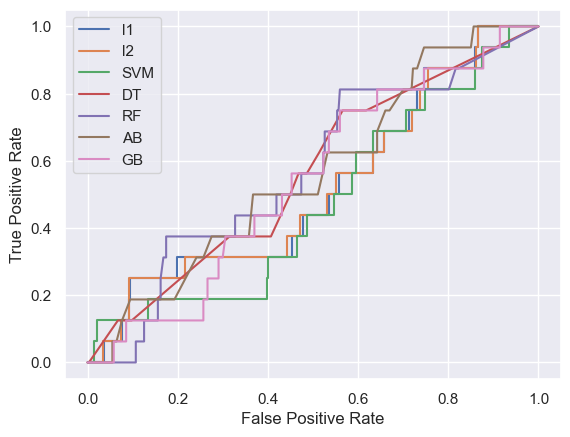

In [72]:
from sklearn import  metrics

for p in predictor:
    f, axs = plt.subplots(1, 1)
    y_test = test[p]
    X_test = test.drop(predictor, axis=1)
    
    
    for k,v in model_dict.items():
        model_name = v
        test_pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
        metrics.RocCurveDisplay.from_estimator(test_pipe, X_test, y_test,name=k,ax=axs) 
        #if v in best_result[best_result["outcome"] == p]["model"].values:
        #    metrics.RocCurveDisplay.from_estimator(test_pipe, X_test, y_test,name=k)
    axs.legend(list(model_dict.keys()))
    axs.set_xlabel('False Positive Rate')
    axs.set_ylabel('True Positive Rate')
    plt.savefig("figure/auc_curves_" + p + ".png",bbox_inches="tight")

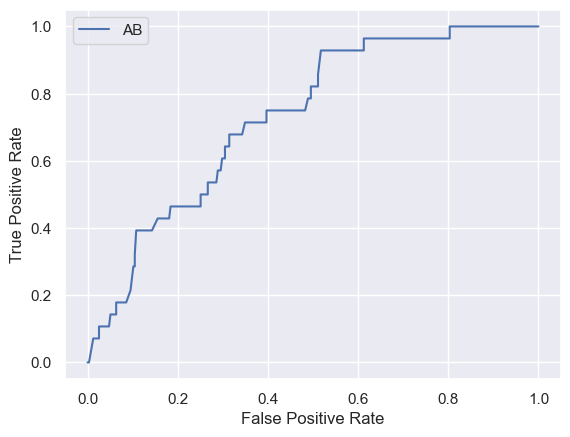

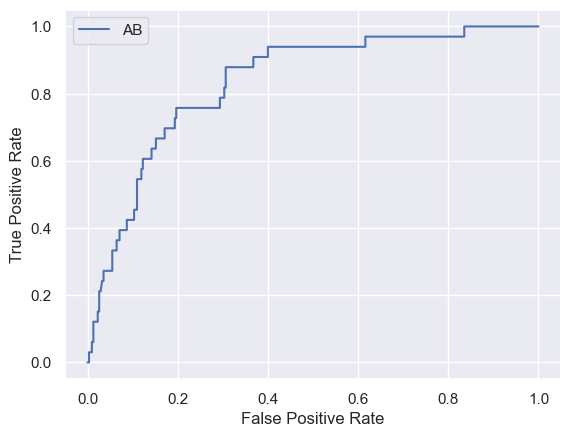

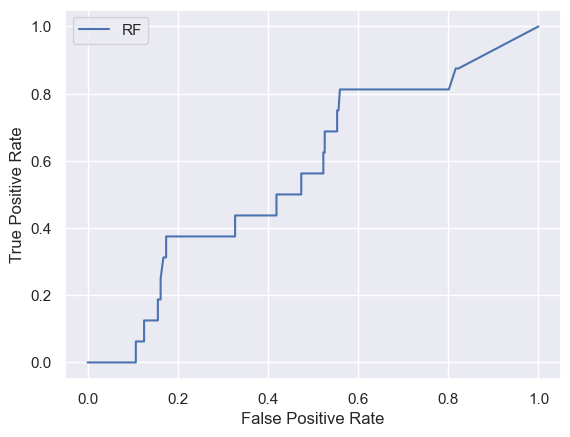

In [71]:
for p in predictor:
    
    y_test = test[p]
    X_test = test.drop(predictor, axis=1)
    
    for k,v in model_dict.items():
        model_name = v
        test_pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
        if v in best_result[best_result["outcome"] == p]["model"].values:
            f, axs = plt.subplots(1, 1)
            metrics.RocCurveDisplay.from_estimator(test_pipe, X_test, y_test,name=k,ax= axs)
            axs.legend([k])
            axs.set_xlabel('False Positive Rate')
            axs.set_ylabel('True Positive Rate')
            plt.savefig("figure/auc_curves_" + p + "_" + k + ".png",bbox_inches="tight")

In [37]:
for p in predictor:
    
    y_test = df_dummy[p]
    X_test = df_dummy.drop(predictor, axis=1)
    
    for k,v in model_dict.items():
        model_name = v
        test_pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
        if v in best_result[best_result["outcome"] == p]["model"].values:
            print(X_test.columns[test_pipe.named_steps["feature_selection"].get_support()])

Index(['respiratory_rate', 'spo2', 'lymphocytes', 'total_wcc', 'platelets',
       'ldh', 'sex_2', 'healthcare_worker_2.0', 'smoker_2.0', 'copd_2.0',
       'dialysis_3.0', 'chest_xray_2', 'chest_xray_3', 'vaccinated_1',
       'coronary_med_history_col_True'],
      dtype='object')
Index(['age', 'respiratory_rate', 'crp', 'total_wcc', 'platelets', 'sex_2',
       'healthcare_worker_2.0', 'hypertension_2.0', 'smoker_2.0', 'asthma_2.0',
       'chest_xray_3', 'vaccinated_1', 'pacemaker_1', 'troponin_uln_2.0',
       'coronary_med_history_col_True'],
      dtype='object')
Index(['ldh', 'creatinine', 'alt', 'sex_2', 'healthcare_worker_2.0',
       'hypertension_2.0', 'smoker_2.0', 'copd_2.0', 'asthma_2.0', 'ckd_2.0',
       'dialysis_3.0', 'chest_xray_3', 'pacemaker_1', 'troponin_uln_2.0',
       'coronary_med_history_col_True'],
      dtype='object')


# Probability Calibration

In [12]:
best_model_dict = {
    'death': 'adaboost_median_impute_feature_oversample',
    'intubation_dummy': 'adaboost_median_impute_feature_oversample',
    'cardio_complication':'rf_selection_median_impute_final_oversample'
}

In [17]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve, CalibrationDisplay
import os
dir = 'C:\\Users\\Harrison Nguyen\\Documents\\CardiacCovidModel\\covid_cardiac\\model\\'

No calibration: 0.183
0.8342619745845552
With isotonic calibration: 0.075
0.8253176930596285
With sigmoid calibration: 0.076
0.816911045943304
No calibration: 0.220
0.7324829931972789
With isotonic calibration: 0.071
0.7454081632653062
With sigmoid calibration: 0.069
0.7592403628117915
No calibration: 0.156
0.5686162079510704
With isotonic calibration: 0.044
0.5581995412844036
With sigmoid calibration: 0.044
0.5737767584097859


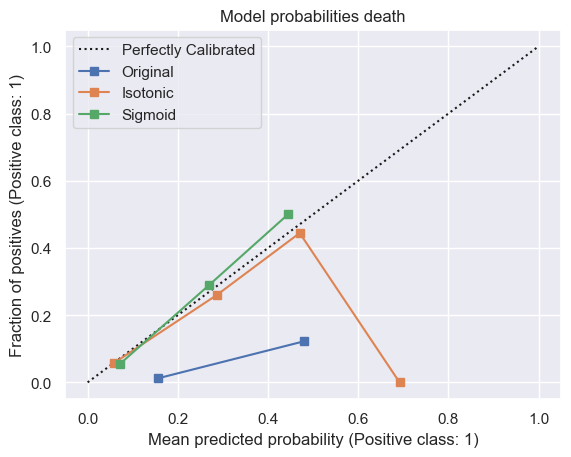

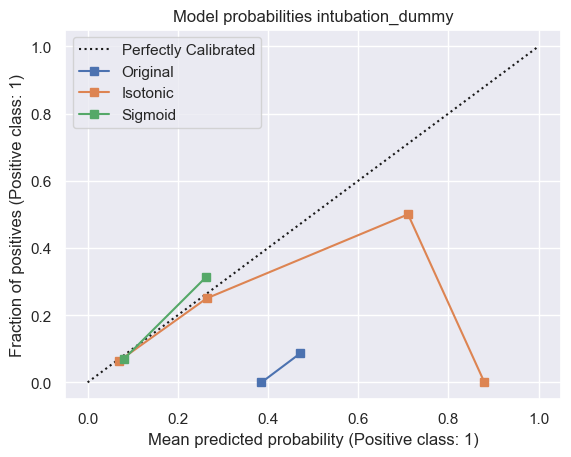

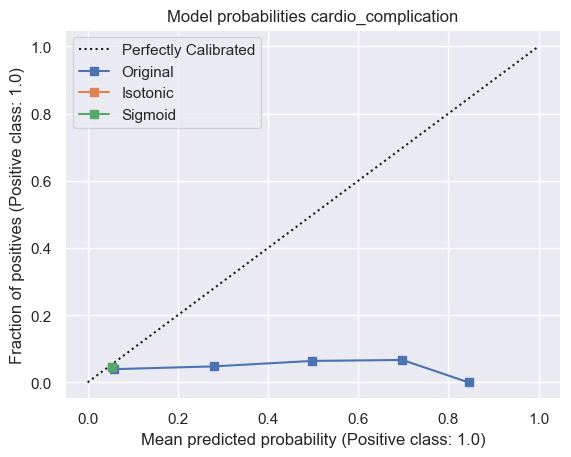

In [21]:
for k,v in best_model_dict.items():
    p = k
    pipe = joblib.load(os.path.join(dir,"{}_{}.pickle".format(v,k)))
        
    y_train = train[p]
    X_train = train.drop(predictor, axis=1)
    
    clf_isotonic = CalibratedClassifierCV(pipe, cv=5, method="isotonic")
    clf_isotonic.fit(X_train, y_train)
    
    joblib.dump(clf_isotonic,"model/" + v + "_" + k + "_isotonic_calibration" +".pickle")

    clf_sigmoid = CalibratedClassifierCV(pipe, cv=5, method="sigmoid")
    clf_sigmoid.fit(X_train, y_train)
    joblib.dump(clf_sigmoid,"model/" + v + "_" + k + "_sigmoid_calibration" +".pickle")


    y_test = test[p]
    X_test = test.drop(predictor, axis=1)

    prob_pos_clf = pipe.predict_proba(X_test)[:, 1]
    clf_score = brier_score_loss(y_test, prob_pos_clf)
    print("No calibration: %1.3f" % clf_score)
    yhat_proba = pipe.predict_proba(X_test)
    print(roc_auc_score(y_test,yhat_proba[:,1]))

    prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]
    clf_isotonic_score = brier_score_loss(y_test, prob_pos_isotonic)
    print("With isotonic calibration: %1.3f" % clf_isotonic_score)
    yhat_proba = clf_isotonic.predict_proba(X_test)
    print(roc_auc_score(y_test,yhat_proba[:,1]))

    prob_pos_sigmoid = clf_sigmoid.predict_proba(X_test)[:, 1]
    clf_sigmoid_score = brier_score_loss(y_test, prob_pos_sigmoid)
    print("With sigmoid calibration: %1.3f" % clf_sigmoid_score)
    yhat_proba = clf_sigmoid.predict_proba(X_test)
    print(roc_auc_score(y_test,yhat_proba[:,1]))
    
    f,ax = plt.subplots()
    CalibrationDisplay.from_estimator(pipe, X_test, y_test,ax=ax)
    CalibrationDisplay.from_estimator(clf_isotonic, X_test, y_test,ax=ax)
    CalibrationDisplay.from_estimator(clf_sigmoid, X_test, y_test,ax=ax)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=["Perfectly Calibrated","Original","Isotonic","Sigmoid"])
    ax.set_title("Model probabilities " + p)
    
    plt.savefig("figure/calibration_plot_" + p +".png",bbox_inches="tight")